In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [55]:
import importlib
import analysis.data.final_dataset as final_dataset
importlib.reload(final_dataset)
from analysis.data.final_dataset import pipeline
sd = "2018-01-01"
ed = "2024-01-01"
dataset = pipeline(sd, ed)

[                       0%                       ]

Total number of tickers 502


[*********************100%***********************]  502 of 502 completed

5 Failed downloads:
['GEV', 'SOLV', 'SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1704085200")')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Null values: False
NaN values: False

Creating features


c:\users\m.narese\desktop\thesis\repo\portfolio_optimization\analysis\data\final_dataset.py:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  dataset_vertical = data.stack(level=1).reset_index()


The dataset has 485 assets
The dataset has 13 predictors:
Ticker
Yavg_return
Yavg_volatility
Davg_span
Davg_volume
D_eSkewness
D_eVaR
D_eCVaR
D_eCurtosis
totalEsg
environmentScore
socialScore
governanceScore
industry
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ticker            485 non-null    object 
 1   Yavg_return       485 non-null    float64
 2   Yavg_volatility   485 non-null    float64
 3   Davg_span         485 non-null    float64
 4   Davg_volume       485 non-null    float64
 5   D_eSkewness       485 non-null    float64
 6   D_eVaR            485 non-null    float64
 7   D_eCVaR           485 non-null    float64
 8   D_eCurtosis       485 non-null    float64
 9   totalEsg          481 non-null    float64
 10  environmentScore  480 non-null    float64
 11  socialScore       480 non-null    float64
 12  governanceScore

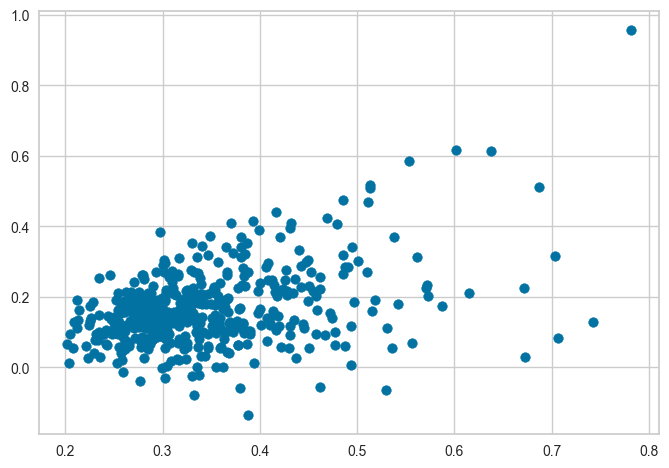

In [56]:
plt.scatter(dataset["Yavg_volatility"], dataset["Yavg_return"])
plt.show()

In [57]:
outliers = outliers = dataset[
    (dataset["Yavg_return"] > 0.8)]["Ticker"].unique()
final_dataframe = dataset[~dataset["Ticker"].isin(outliers)]
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,totalEsg,environmentScore,socialScore,governanceScore,industry
0,A,0.170254,0.290318,2.268208,1.961764e+06,-0.134994,-0.000283,-0.000401,4.334477,11.36,1.19,6.23,3.93,Life Sciences Tools and Services
1,AAPL,0.309906,0.316770,2.378506,1.073273e+08,-0.036493,-0.000292,-0.000426,4.924365,16.79,0.55,7.52,8.72,Technology
2,ABBV,0.159055,0.273195,2.003774,7.196053e+06,-0.845038,-0.000286,-0.000483,13.941105,26.10,1.78,15.70,8.62,Biotechnology
3,ABT,0.155088,0.257788,1.733056,5.701730e+06,0.048215,-0.000290,-0.000434,6.096855,22.21,1.81,13.84,6.56,Health Care
4,ACGL,0.204344,0.314158,0.905297,1.859299e+06,-0.321692,-0.000771,-0.001249,11.651915,20.27,1.57,9.92,8.78,Insurance


In [58]:
stock_data_clustering = final_dataframe[["Yavg_return",	"Yavg_volatility"]]

stock_data_clustering = stock_data_clustering.drop(columns=["Ticker"])
stock_data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 484 entries, 0 to 484
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Yavg_return      484 non-null    float64
 1   Yavg_volatility  484 non-null    float64
dtypes: float64(2)
memory usage: 11.3 KB


In [59]:
from sklearn.preprocessing import MinMaxScaler
for attr in stock_data_clustering.columns:
    scaler = MinMaxScaler()
    stock_data_clustering[attr] = scaler.fit_transform(stock_data_clustering[attr].values.reshape(-1, 1)).flatten()

In [60]:
#---------------------------------------------------------------------
# to compute distances for the centroid methodology (KMeans)
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#----------------------------------------------------------------------
# to compute distances for the hierarchical clustering
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

#----------------------------------------------------------------------
# good practice
%matplotlib inline

# to remove warnings
# import warnings
# warnings.filterwarnings('ignore')

In [61]:
clusters = range(2, 20)
meanDistortions = []
sil_score = []
inertias = []
runs = 60
for i in range(runs):
    run_sil = []
    run_dist = []
    run_in = []
    for k in clusters:
        model = KMeans(n_clusters=k, random_state=i)
        model.fit(stock_data_clustering)
        prediction = model.predict(stock_data_clustering)
        score = silhouette_score(stock_data_clustering, prediction)
        distortion = (
            sum(
                np.min(cdist(stock_data_clustering, model.cluster_centers_, "euclidean"), axis=1)
            )
            / stock_data_clustering.shape[0]
        )
        run_in.append(model.inertia_)
        run_dist.append(distortion)
        run_sil.append(score)
    sil_score.append(run_sil)
    meanDistortions.append(run_dist)
    inertias.append(run_in)
        # print("\nNumber of Clusters:", k, "\tAverage Distortion:", distortion)
        # print("For n_clusters = {}, silhouette score is {}".format(k, score))

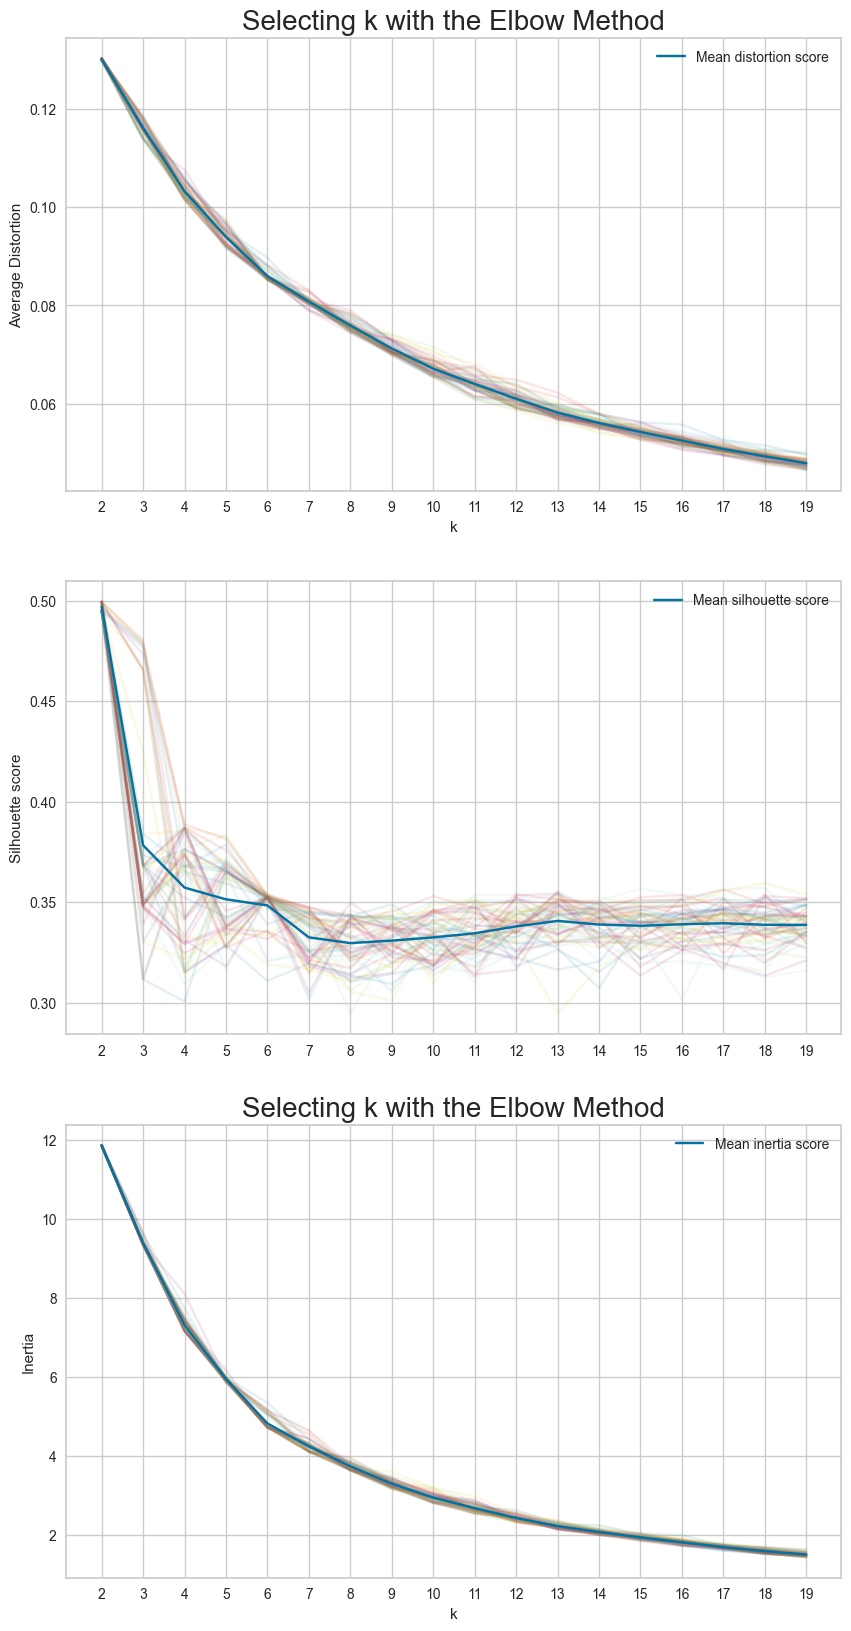

In [62]:
plt.figure(figsize=(10,20))
plt.subplot(3,1,1)
for i in range(runs): 
    plt.plot(clusters, meanDistortions[i], color=f"C{i}", alpha = 0.1)
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.xticks(clusters)
plt.title("Selecting k with the Elbow Method", fontsize=20)
plt.plot(clusters, np.mean(np.array(meanDistortions), axis=0), label="Mean distortion score")
plt.legend()
plt.subplot(3,1,2)
for i in range(runs): 
    plt.plot(clusters, sil_score[i], color=f"C{i}", alpha = 0.1)
plt.ylabel("Silhouette score")
# plt.ylim(0.1, 0.3)
plt.xticks(clusters)
plt.plot(clusters, np.mean(np.array(sil_score), axis=0), label="Mean silhouette score")
plt.legend()
plt.subplot(3,1,3)
for i in range(runs): 
    plt.plot(clusters, inertias[i], color=f"C{i}", alpha = 0.1)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.xticks(clusters)
plt.title("Selecting k with the Elbow Method", fontsize=20)
plt.plot(clusters, np.mean(np.array(inertias), axis=0), label="Mean inertia score")
plt.legend()
plt.show()

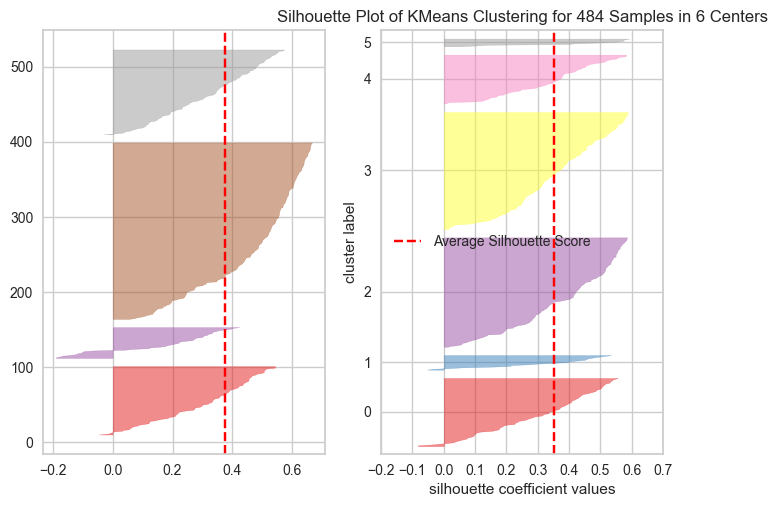

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 484 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [63]:
plt.subplot(1,2,1)
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(stock_data_clustering)
plt.subplot(1,2,2)
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))

visualizer.fit(stock_data_clustering)

visualizer.show()

In [105]:
N_SECTORS = 6

kmeans = KMeans(n_clusters=N_SECTORS, random_state=0)
kmeans.fit(stock_data_clustering)
final_dataframe["Sector"] = kmeans.labels_
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,totalEsg,environmentScore,socialScore,governanceScore,industry,K_means_segments,Sector
0,A,0.170254,0.290318,2.268208,1.961764e+06,-0.134994,-0.000283,-0.000401,4.334477,11.36,1.19,6.23,3.93,Life Sciences Tools and Services,0,0
1,AAPL,0.309906,0.316770,2.378506,1.073273e+08,-0.036493,-0.000292,-0.000426,4.924365,16.79,0.55,7.52,8.72,Technology,4,4
2,ABBV,0.159055,0.273195,2.003774,7.196053e+06,-0.845038,-0.000286,-0.000483,13.941105,26.10,1.78,15.70,8.62,Biotechnology,0,0
3,ABT,0.155088,0.257788,1.733056,5.701730e+06,0.048215,-0.000290,-0.000434,6.096855,22.21,1.81,13.84,6.56,Health Care,0,0
4,ACGL,0.204344,0.314158,0.905297,1.859299e+06,-0.321692,-0.000771,-0.001249,11.651915,20.27,1.57,9.92,8.78,Insurance,4,4


In [106]:
cluster_profile = final_dataframe.groupby("Sector").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = final_dataframe.groupby("Sector")["Ticker"].count().values
cluster_profile["Sharpe_ratio"] = (cluster_profile["Yavg_return"]-0.02)/cluster_profile["Yavg_volatility"]
cluster_profile.style.highlight_max(color="green", axis=0)

,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,totalEsg,environmentScore,socialScore,governanceScore,K_means_segments,Count,Sharpe_ratio
Sector,,,,,,,,,,,,,,,
0,0.125860,0.271997,2.610616,3566153.756368,-0.164795,-0.000384,-0.000612,11.763848,20.499436,6.152974,9.064718,5.281538,0.000000,195,0.389194
1,0.397875,0.488224,4.961252,27252647.165894,0.069113,-0.001080,-0.001680,11.382692,19.771667,6.113103,8.417931,5.216552,1.000000,30,0.773979
2,0.141946,0.448964,2.549813,6973865.986243,-0.086304,-0.001040,-0.001657,13.846528,21.530000,6.455000,8.946481,6.127963,2.000000,54,0.271616
3,0.078211,0.347453,2.008640,5290505.530966,-0.107989,-0.000790,-0.001254,12.896696,20.789412,5.383412,9.367412,6.038588,3.000000,88,0.167537
4,0.239756,0.340443,5.702918,5250826.356193,0.011244,-0.000403,-0.000630,10.155836,18.759231,4.319038,8.858077,5.582500,4.000000,105,0.645501
5,0.172979,0.625919,2.518135,10231385.574332,0.045047,-0.001752,-0.003117,21.088919,28.146667,12.430833,10.224167,5.491667,5.000000,12,0.244408


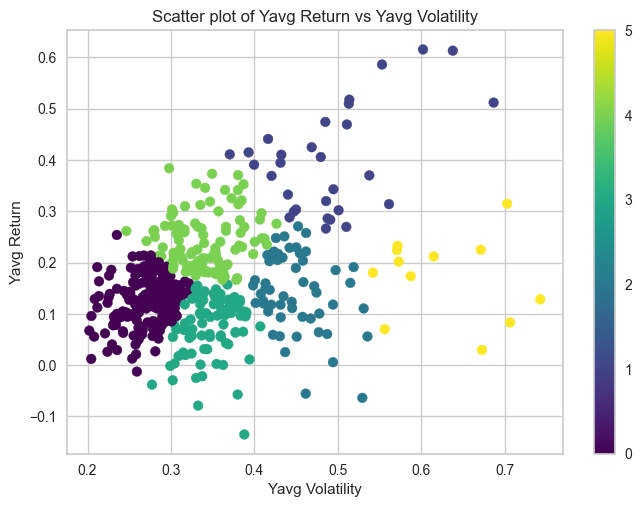

In [107]:
plt.scatter(
    final_dataframe["Yavg_volatility"], 
    final_dataframe["Yavg_return"], 
    c=final_dataframe["Sector"],  # Use c for color mapping
    cmap='viridis',  # Optional: Choose a colormap
    
)

# Add labels and title
plt.xlabel("Yavg Volatility")
plt.ylabel("Yavg Return")
plt.title("Scatter plot of Yavg Return vs Yavg Volatility")
plt.colorbar()
# Show the plot
plt.show()

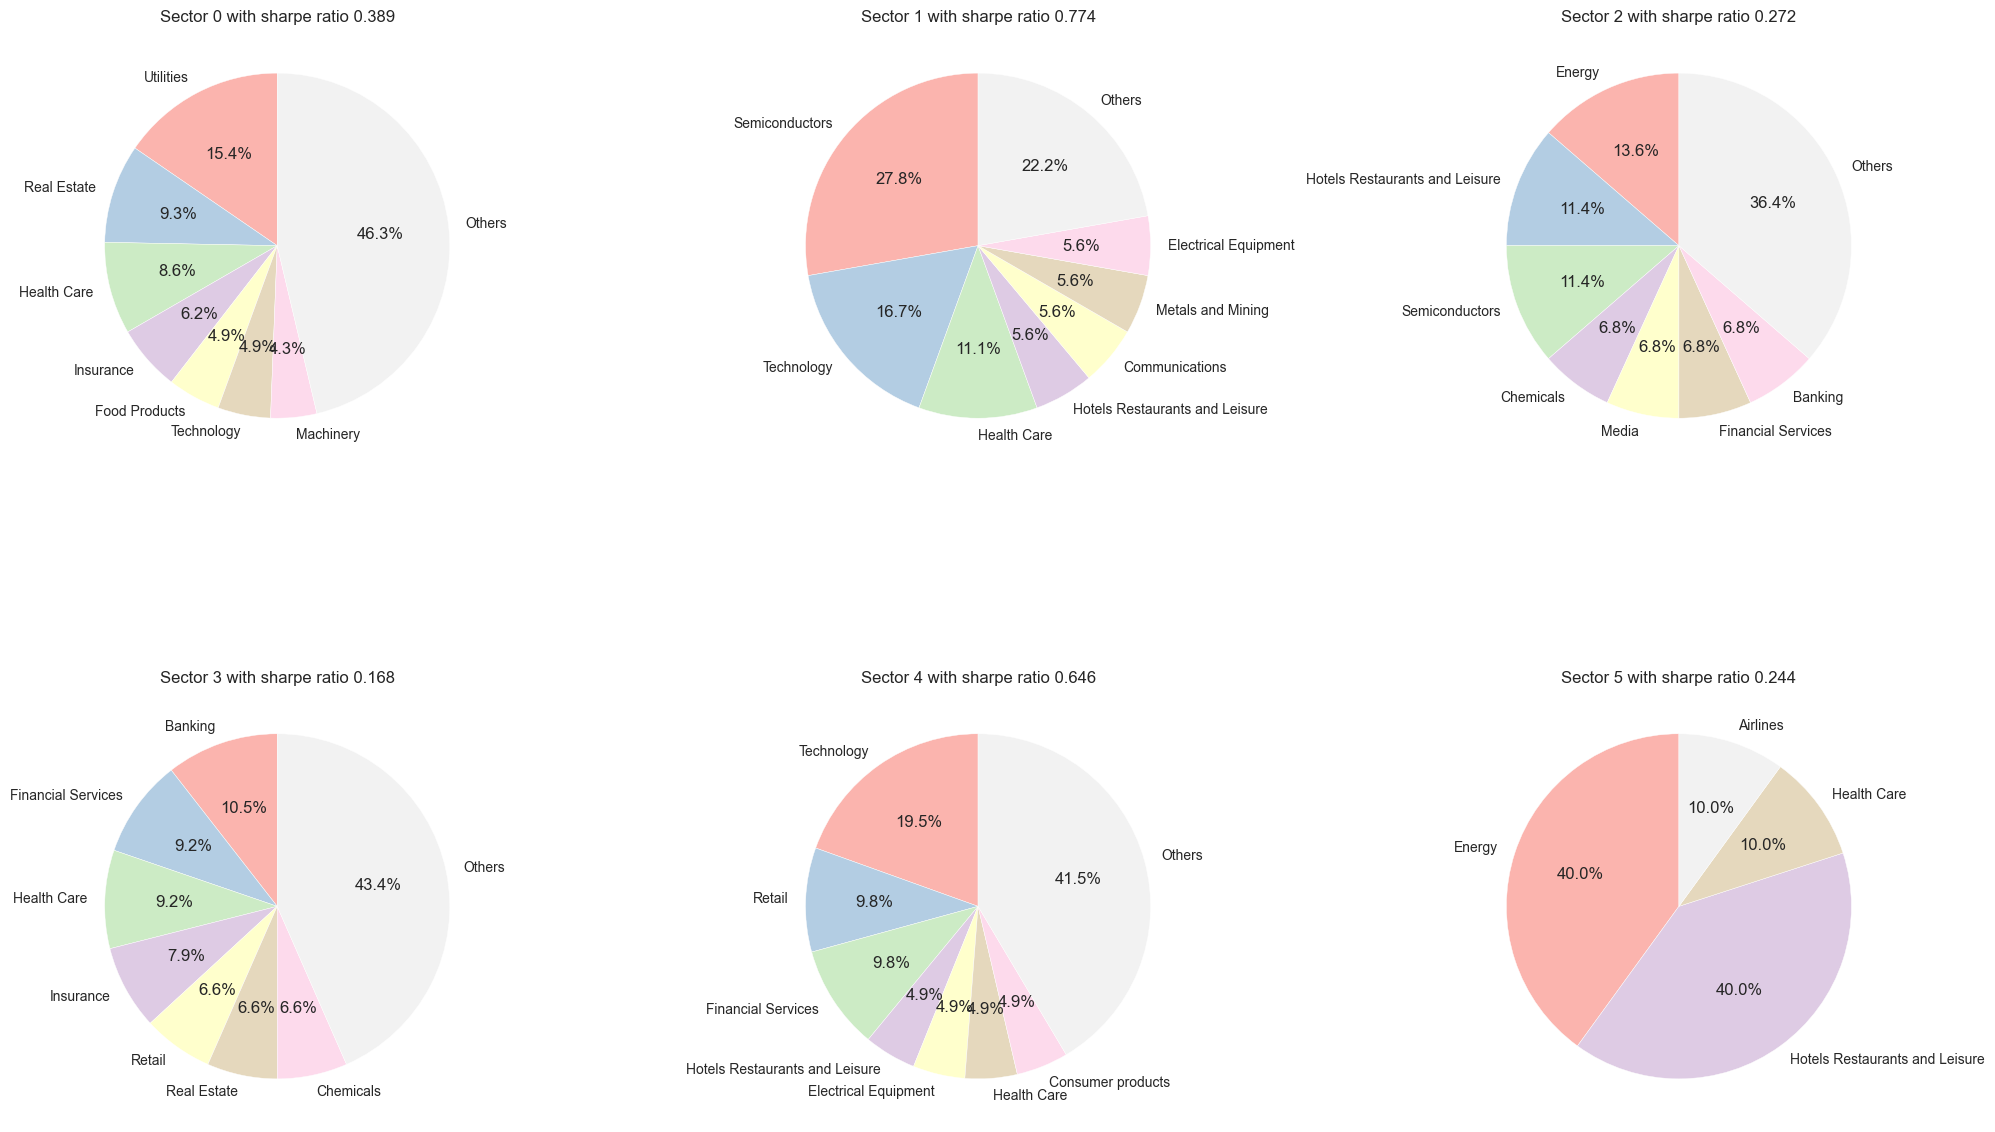

In [108]:
MAX_LABELS = 7
colormap = plt.get_cmap('Pastel1')
# Get unique sectors
sectors = sorted(final_dataframe["Sector"].unique())
i = 1

plt.figure(figsize=(20, 20))

for sector in sectors:
    # Count industries in the current sector
    focus = final_dataframe[final_dataframe["Sector"] == sector]["industry"].value_counts()
    
    # Group "Others" if there are too many industries
    if len(focus) > MAX_LABELS:
        others = pd.Series(focus[MAX_LABELS:].sum(), index=["Others"])
        focus = pd.concat([focus[:MAX_LABELS], others])
    num_labels = len(focus)
    colors = colormap(np.linspace(0, 1, num_labels))
    # Plot the pie chart
    plt.subplot(3, 3, i)
    wedges, texts, autotexts =  plt.pie(
        focus.values,
        labels=focus.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        normalize=True

    )
    

# Change color of percentage labels to red
    # for autotext in autotexts:
    #     autotext.set_color('white')
    sr = cluster_profile[cluster_profile.reset_index()['K_means_segments'] == sector].reset_index()['Sharpe_ratio'].values[0]
    plt.title(f"Sector {sector} with sharpe ratio {np.round(sr, 3)}")
    i += 1

plt.tight_layout()
plt.show()

In [ ]:
import analysis.data.final_dataset as final_dataset
importlib.reload(final_dataset)
from analysis.data.final_dataset import create_portfolio_clustered
portfolio_ret, asset_ret = create_portfolio_clustered(sd, ed, final_dataframe, list(final_dataframe["Ticker"]))


In [112]:
benchmark = yf.download(tickers="SPY", start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


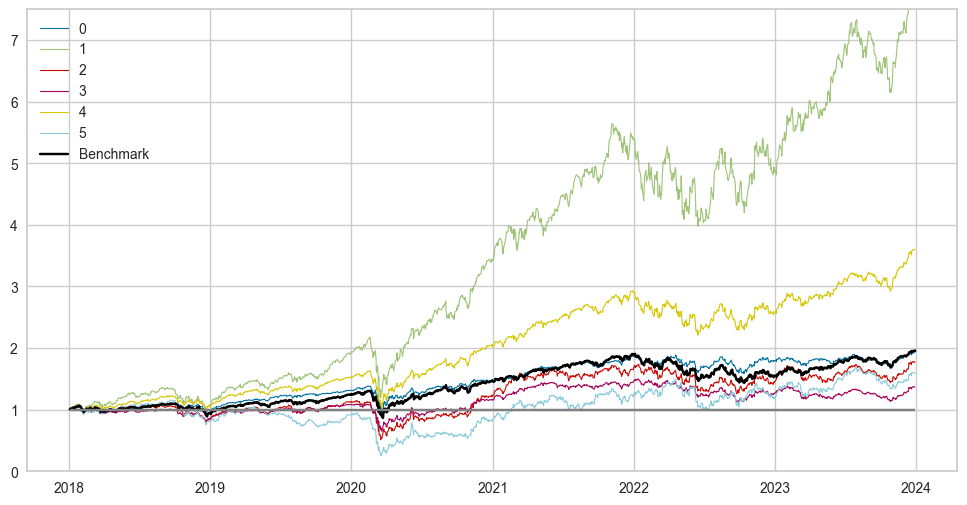

In [154]:
import pandas as pd
import matplotlib.pyplot as plt

portfolio_evolution = pd.DataFrame(asset_ret["Date"])
plt.figure(figsize=(12, 6))
portfolio_evolution["SPY"] = (1 + benchmark.reset_index()["SPY"].pct_change()).cumprod()
for portfolio in portfolio_ret.reset_index().columns:
    if portfolio != "Date":
        portfolio_evolution[portfolio] = (1 + portfolio_ret.reset_index()[portfolio]).cumprod()
        plt.plot(portfolio_evolution["Date"], portfolio_evolution[portfolio], label = portfolio, color = f"C{int(portfolio)}", alpha = 1, linewidth=0.8)
plt.plot(portfolio_evolution["Date"], portfolio_evolution["SPY"], label = "Benchmark", color="black")#, color = f"C{int(portfolio)+1}", linewidth=2)
plt.hlines(1, xmin=min(portfolio_evolution["Date"]), xmax=max(portfolio_evolution["Date"]), color = "grey")
plt.ylim(0, 7.5)
plt.legend()
plt.show()



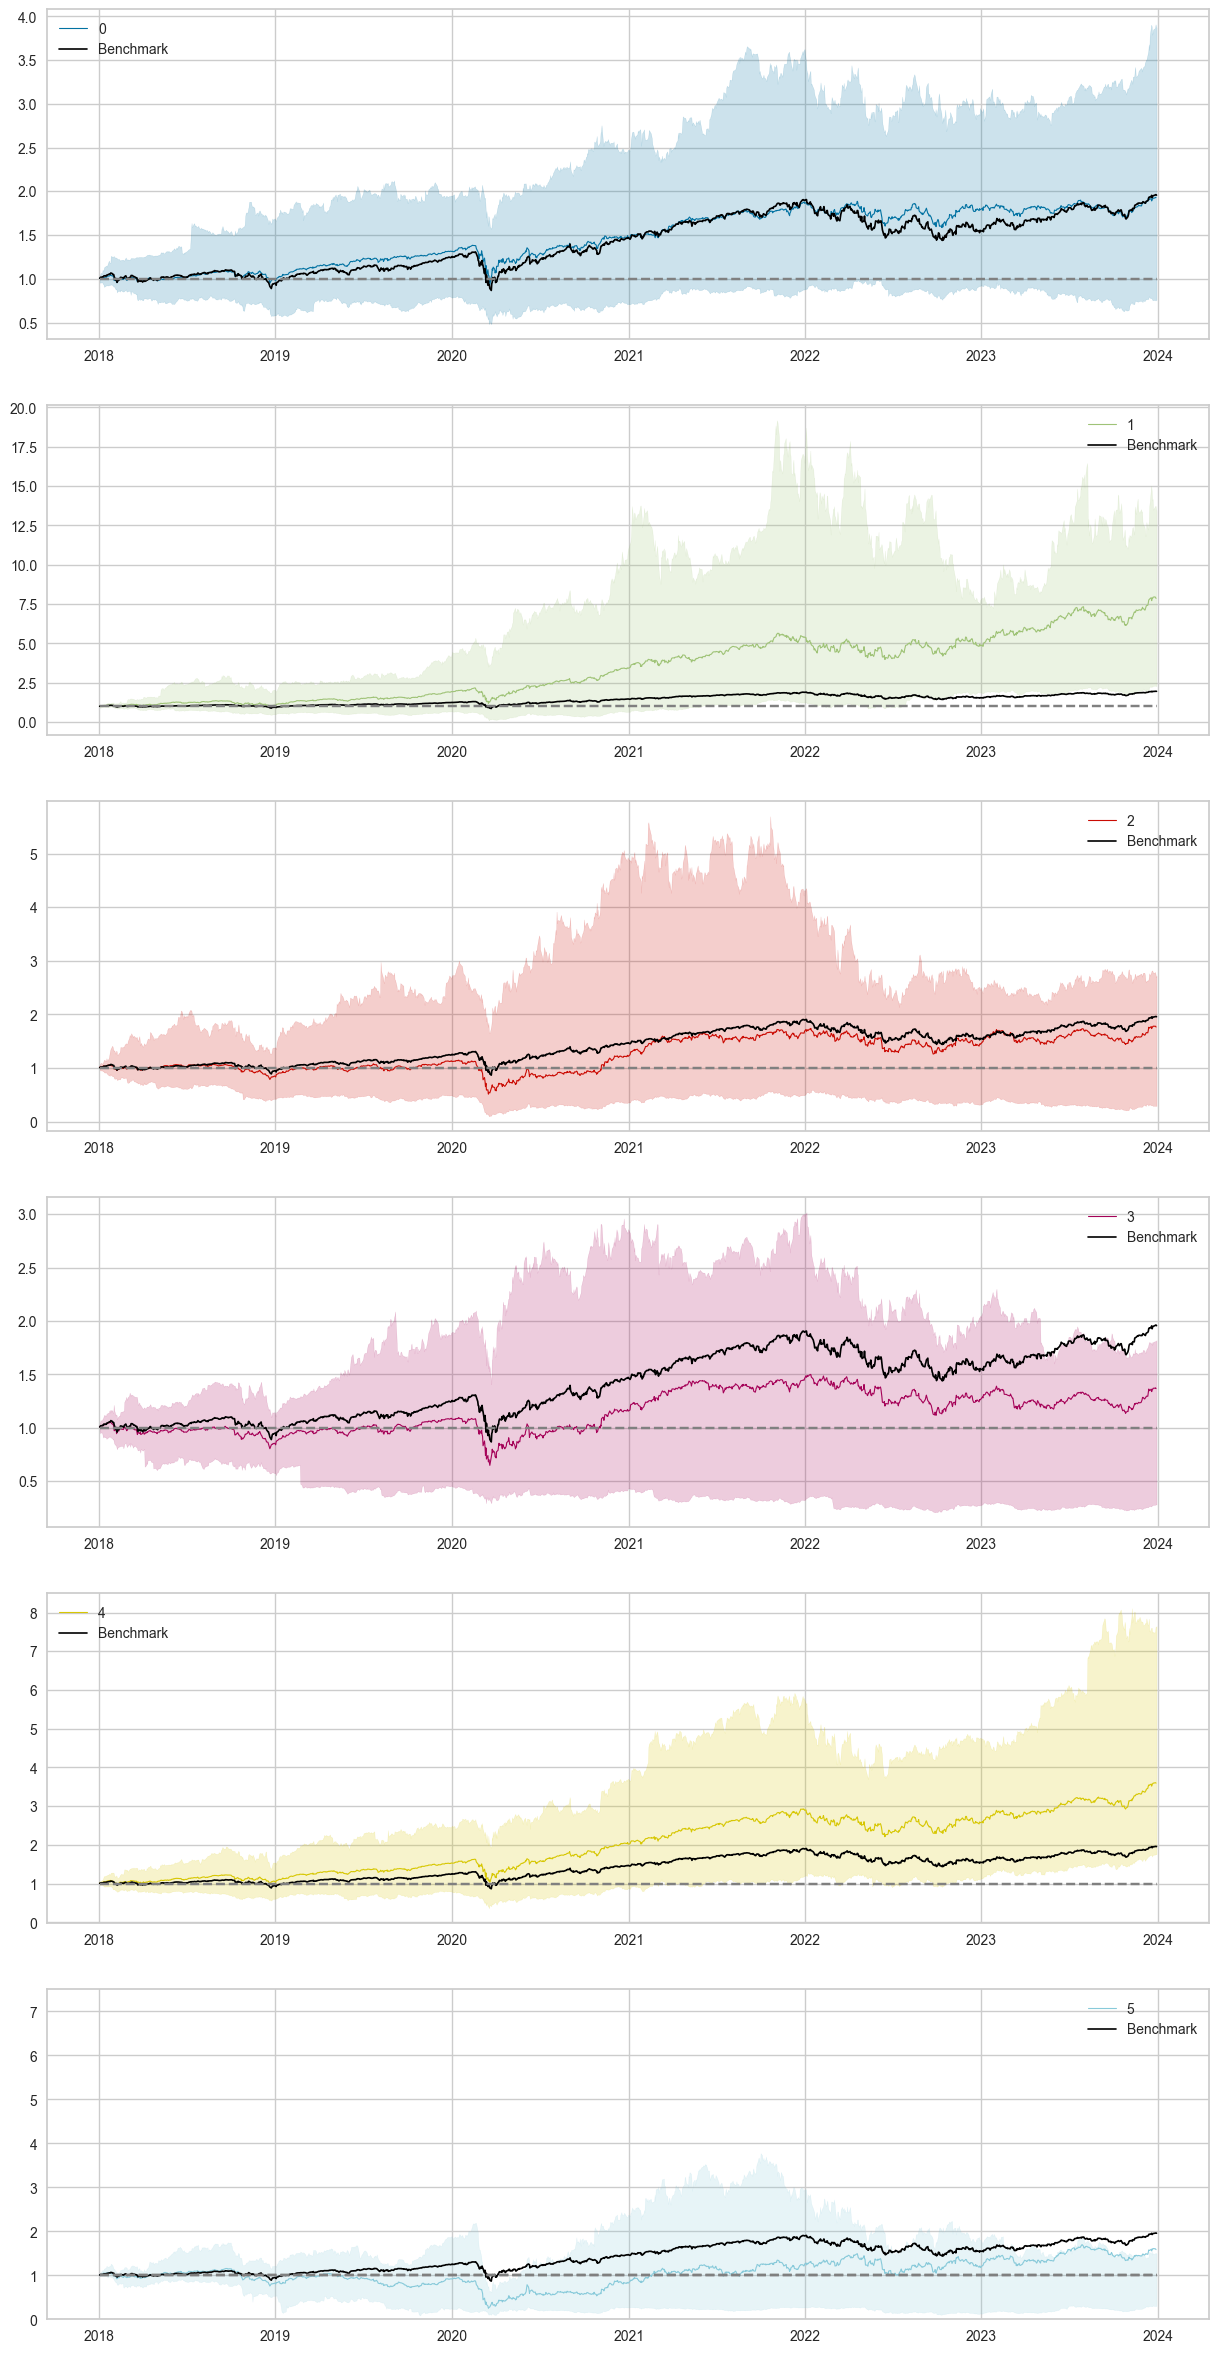

In [152]:
import pandas as pd
import matplotlib.pyplot as plt

portfolio_evolution = pd.DataFrame(asset_ret["Date"])

plt.figure(figsize=(15, 30))

# Dictionary to store portfolio cumulative returns
portfolio_groups = {}
portfolio_evolution["SPY"] = (1 + benchmark.reset_index()["SPY"].pct_change()).cumprod()
for portfolio in asset_ret.columns:
    if portfolio != "Date":
        # Get portfolio label from clustering dataframe
        lab = final_dataframe.loc[final_dataframe["Ticker"] == portfolio, "K_means_segments"].values[0]
        
        # Compute cumulative returns
        portfolio_evolution[portfolio] = (1 + asset_ret[portfolio]).cumprod()
        
        # Store returns grouped by portfolio
        if lab not in portfolio_groups:
            portfolio_groups[lab] = []
        portfolio_groups[lab].append(portfolio_evolution[portfolio])

# Convert grouped lists to DataFrames
for lab, assets in portfolio_groups.items():
    plt.subplot(N_SECTORS, 1, int(lab)+1)
    asset_group_df = pd.concat(assets, axis=1)
    
    # Compute min and max across assets in the portfolio
    min_returns = asset_group_df.min(axis=1)
    max_returns = asset_group_df.max(axis=1)
    
    # Shade area between min and max
    plt.fill_between(portfolio_evolution["Date"], min_returns, max_returns, color=f"C{int(lab)}", alpha=0.2)

# Plot each portfolio's average return
for portfolio in portfolio_ret.reset_index().columns:
    if portfolio != "Date":
        plt.subplot(N_SECTORS, 1, int(portfolio)+1)
        portfolio_evolution[portfolio] = (1 + portfolio_ret.reset_index()[portfolio]).cumprod()
        plt.plot(portfolio_evolution["Date"], portfolio_evolution[portfolio], label=portfolio, color=f"C{int(portfolio)}", alpha=1, linewidth=0.8)
        plt.plot(portfolio_evolution["Date"], portfolio_evolution["SPY"], label="Benchmark", color="black", linewidth=1.2)
        plt.legend()
        plt.hlines(1, xmin=min(portfolio_evolution["Date"]), xmax=max(portfolio_evolution["Date"]), color="grey", linestyle="--")


# Plot the benchmark (SPY)



# Add horizontal line at 1
plt.hlines(1, xmin=min(portfolio_evolution["Date"]), xmax=max(portfolio_evolution["Date"]), color="grey", linestyle="--")

plt.ylim(0, 7.5)
plt.legend()
plt.show()


In [ ]:
sd_test = ed
ed_test = "2025-01-10"
portfolio_ret_t, asset_ret_t = create_portfolio_clustered(sd_test, ed_test, final_dataframe, list(final_dataframe["Ticker"]))

In [127]:
benchmark_t = yf.download(tickers="SPY", start=sd_test, end=ed_test, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


In [139]:
def weights(ratios, cluster, pow, thresh):
    w = np.array(ratios["Sharpe_ratio"] > thresh)*ratios["Sharpe_ratio"]
    ratios["weights"] = np.power(w, pow)
    ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
    return ratios.loc[ratios["Sector"] == cluster, "weights"]

In [145]:
import quantstats as qs

returns = np.zeros(len(portfolio_ret_t))
cp = cluster_profile.reset_index()
for i in portfolio_ret_t.columns:
        weight = weights(cp[["Sector", "Sharpe_ratio"]], i, 3, 0.25).values[0]
        returns += weight*portfolio_ret_t[i] 
portfolio_performance = pd.DataFrame(returns).reset_index()

0.07263691513616886
0.571275966440547
0.024690083580836405
0.0
0.3313970348424477
0.0


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-01-04   2024-01-04
End Period                 2025-01-08   2025-01-08
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          27.36%       30.53%
CAGR﹪                     17.91%       19.9%

Sharpe                     1.96         1.61
Prob. Sharpe Ratio         97.18%       94.38%
Smart Sharpe               1.95         1.6
Sortino                    2.86         2.38
Smart Sortino              2.84         2.37
Sortino/√2                 2.02         1.68
Smart Sortino/√2           2.01         1.67
Omega                      1.3          1.3

Max Drawdown               -8.41%       -10.5%
Longest DD Days            64           64
Volatility (ann.)          12.57%       17.34%
R^2                        0.83         0.83
Information Ratio          0.03         0.03
Calmar                  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-07-17,2024-08-05,2024-09-18,64,-10.498317,-10.309512
2,2024-04-01,2024-04-19,2024-05-14,44,-7.486085,-6.815091
3,2024-12-05,2024-12-19,2025-01-08,35,-7.175200,-7.072060
4,2024-10-15,2024-10-31,2024-11-05,22,-4.085952,-3.676955
5,2024-11-12,2024-11-15,2024-11-21,10,-4.058594,-3.092465


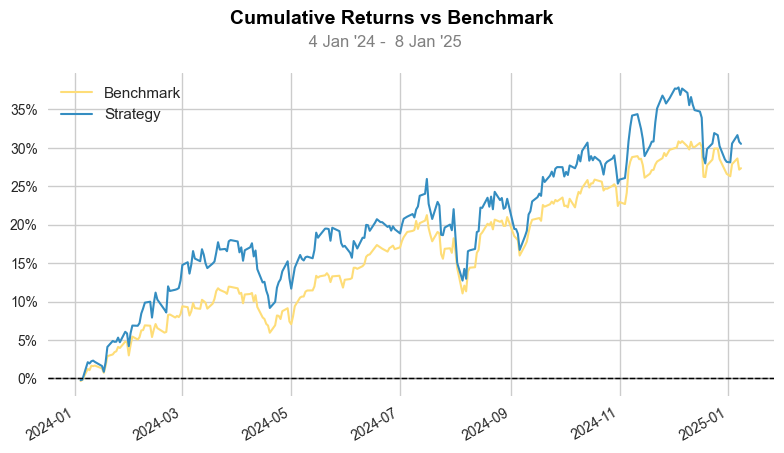

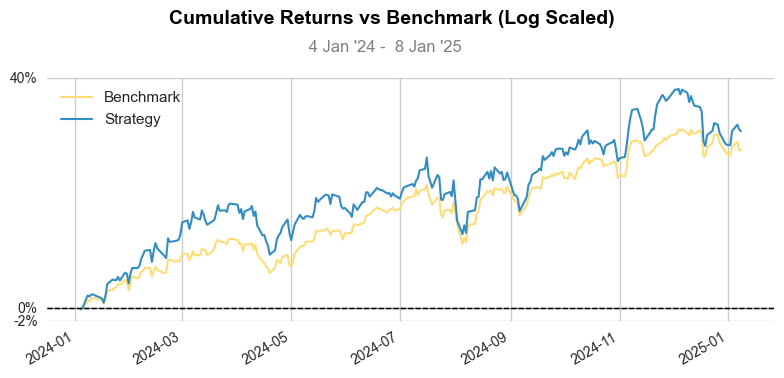

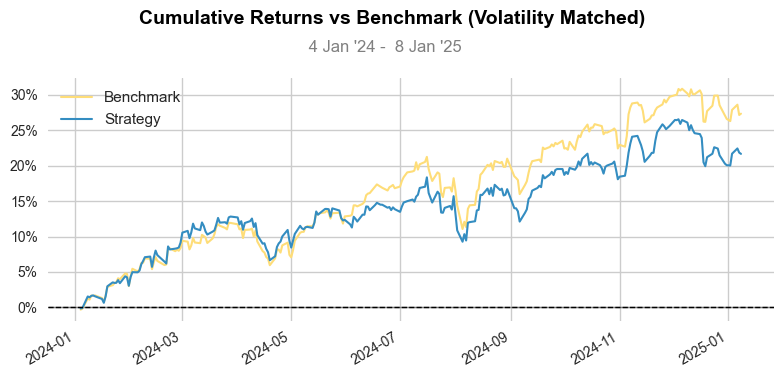

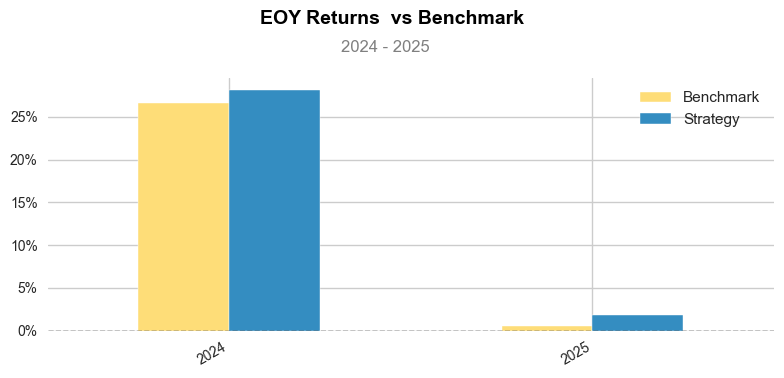

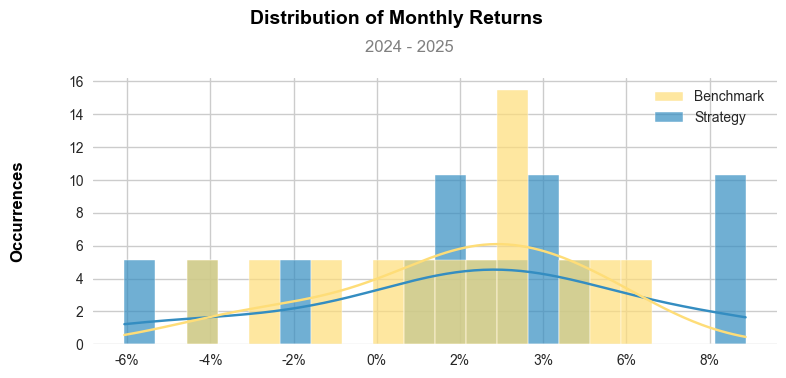

UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [146]:
portfolio_performance["Date"] = pd.to_datetime(portfolio_performance["Date"])

# Set "Date" as the index
portfolio_performance.set_index("Date", inplace=True)

# Rename the column for better clarity (optional)
portfolio_performance.columns = ["Returns"]

# Ensure the returns are properly formatted and call the quantstats report
qs.reports.full(portfolio_performance["Returns"], benchmark="SPY")

In [69]:
pr = portfolio_returns.reset_index()
pr[pr["Date"] > pd.to_datetime("2024-12-20")]

K_means_segments,Date,0,1,2,3
245,2024-12-23,0.004195,0.007809,0.008285,0.001691
246,2024-12-24,0.008732,-0.003404,0.015188,0.007176
247,2024-12-26,0.002614,-0.010290,0.027819,0.003039
248,2024-12-27,-0.009650,1.979713,-0.009068,-0.006809
249,2024-12-30,-0.005983,-0.026496,0.016839,-0.008847
250,2024-12-31,0.001720,0.179600,-0.027602,0.002299
251,2025-01-02,-0.001689,0.002042,0.024373,-0.004563
252,2025-01-03,0.014869,0.053555,0.021650,0.007363
253,2025-01-06,0.007759,0.022131,-0.005896,-0.001749
254,2025-01-07,-0.004927,-0.006233,0.010264,-0.002559
